In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [27]:
mnist_train = pd.read_csv("datasets/mnist-in-csv/mnist_train.csv")
mnist_test = pd.read_csv("datasets/mnist-in-csv/mnist_test.csv")

In [28]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

In [30]:
random_sel = mnist_train.sample(8)
random_sel.shape

(8, 785)

In [31]:
image_features = random_sel.drop("label", axis=1)
image_batch = (torch.Tensor(image_features.values / 255.0)).reshape((-1, 28, 28))
image_batch.shape

torch.Size([8, 28, 28])

In [32]:
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8)
grid.shape

torch.Size([3, 32, 242])

(-0.5, 241.5, 31.5, -0.5)

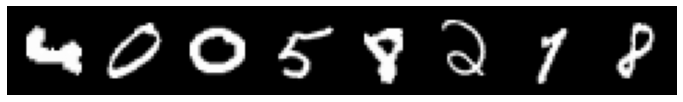

In [33]:
plt.figure(figsize=(12, 12))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")

In [34]:
mnist_train_features = mnist_train.drop("label", axis=1)
mnist_train_target = mnist_train["label"]

mnist_test_features = mnist_test.drop("label", axis=1)
mnist_test_target = mnist_test["label"]

In [35]:
X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
x_test_tensor = torch.tensor(mnist_test_features.values, dtype=torch.float)

Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)
y_test_tensor = torch.tensor(mnist_test_target.values, dtype=torch.long)

In [36]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [37]:
X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28)
x_test_tensor = x_test_tensor.reshape(-1, 1, 28, 28)

In [38]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [39]:
in_size = 1
hid1_size = 16
# hid1_size = 8
hid2_size = 32
out_size = 10
k_conv_size = 5

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc = nn.Linear(512, out_size)

    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)

        out = self.layer2(out)
        # print(out.shape)

        out = out.reshape(out.size(0), -1)
        # print(out.shape)

        out = self.fc(out)
        # print(out.shape)

        return out  # F.log_softmax(out, dim=-1)

In [41]:
model = ConvNet()

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [43]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [44]:
X_train_tensor = X_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)

Y_train_tensor = Y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [45]:
learning_rate = 0.001
# learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [46]:
num_epochs = 10
loss_values = list()

In [47]:
for epoch in range(1, num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("Epoch - %d, loss - %0.5f " % (epoch, loss.item()))
    loss_values.append(loss.item())

Epoch - 1, loss - 2.34762 
Epoch - 2, loss - 2.33146 
Epoch - 3, loss - 2.30194 
Epoch - 4, loss - 2.26238 
Epoch - 5, loss - 2.21616 
Epoch - 6, loss - 2.16630 
Epoch - 7, loss - 2.11517 
Epoch - 8, loss - 2.06433 
Epoch - 9, loss - 2.01454 


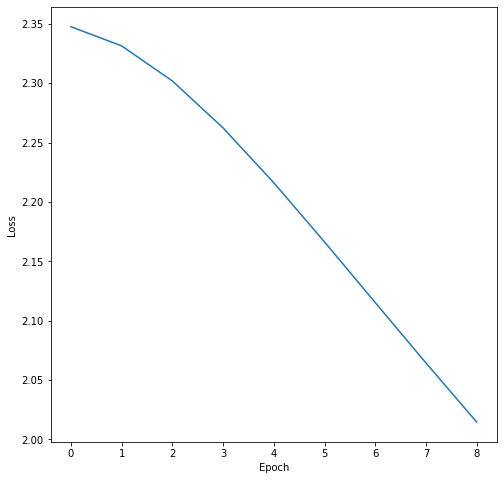

In [48]:
x = range(0, 9)
plt.figure(figsize=(8, 8))
plt.plot(x, loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss");

In [49]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [50]:
with torch.no_grad():
    correct = 0
    total = 0

    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

    y_test = y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()

    print("Accuracy: ", accuracy_score(predicted, y_test))
    print("Precision: ", precision_score(predicted, y_test, average="weighted"))
    print("Recall: ", recall_score(predicted, y_test, average="weighted"))

Accuracy:  0.2923
Precision:  0.5994627884997253
Recall:  0.2923
